# Noise model

## Maximum Filter and Minimum Filter（最大和最小滤波器）

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def max_filter(image, ksize=3):
    """
    最大值滤波函数
    :param image: 输入要图像
    :param ksize: 模板尺寸
    :return: 滤波结果图像
    """
    border_width = int((ksize-1)/2)  # 边界填充宽度
    # 填充便捷操作
    border_filling = cv2.copyMakeBorder(image,
                                        border_width, border_width, border_width, border_width,
                                        cv2.BORDER_REPLICATE)
    max_image = image.copy()
    for i in range(border_width, border_filling.shape[0]-border_width):
        for j in range(border_width, border_filling.shape[1]-border_width):
            # 读取模板下像素的灰度值
            lists = []
            for s in range(i-border_width, i+border_width+1):
                for t in range(j-border_width, j+border_width+1):
                    lists.append(border_filling[s][t])
            # 选最大值作为输出图像模板中心像素的灰度值
            max_image[i-border_width][i-border_width] = max(lists)
    return max_image


def min_filter(image, ksize=3):
    """
    最小值滤波函数
    :param image:输入图像
    :param ksize:模板尺寸
    :return:滤波结果图像
    """
    border_width = int((ksize-1)/2)  # 边界填充宽度
    # 填充边界操作
    border_filling = cv2.copyMakeBorder(image,
                                        border_width, border_width, border_width, border_width,
                                        cv2.BORDER_REPLICATE)
    # 从[(ksize-1)/2, (ksize-1)/2]开始向右下角进行漫游重合，
    # 到[borderFilling.shape[0]-3, borderFilling.shape[1]-3]停止
    min_image = image.copy()
    for i in range(border_width, border_filling.shape[0]-border_width):
        for j in range(border_width, border_filling.shape[1]-border_width):
            # 读取模板下像素的灰度值
            lists = []
            for s in range(i-border_width, i+border_width+1):
                for t in range(j-border_width, j+border_width+1):
                    lists.append(border_filling[s][t])
            # 选最大值作为输出图像模板中心像素的灰度值
            min_image[i-border_width][j-border_width] = min(lists)
    return min_image


## Meadian Filter（中值滤波器）

In [4]:
# 中值滤波器直接调用函数
# img_median = cv2.medianBlur(image, ksize)

## Adapt Meadian Filter（自适应中值滤波器）
> * dynamically change the window size of the median filter 

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def AdaptProcess(src, i, j, minSize, maxSize):
    """
    自适应中值滤波器具体实现
    :imge: 输入图像
    :minsize: 模板大小下限（初始值）
    :maxsize: 模板大小上限
    :i:待处理像素坐标(模板对应的图像部分的中心点)
    :j:待处理像素坐标(模板对应的图像部分的中心点)
    :return:返回该模板对应区域中的滤波结果像素值
    """

    filter_size = minSize
    kernelSize = filter_size // 2
    rio = src[i-kernelSize:i+kernelSize+1, j-kernelSize:j+kernelSize+1]
    minPix = np.min(rio)
    maxPix = np.max(rio)
    medPix = np.median(rio)
    zxy = src[i, j]
    if (medPix > minPix) and (medPix < maxPix):
        if (zxy > minPix) and (zxy < maxPix):
            return zxy
        else:
            return medPix
    else:
        filter_size = filter_size + 2
        if filter_size <= maxSize:
            return AdaptProcess(src, i, j, filter_size, maxSize)
        else:
            return medPix


def adaptMeadianFilter(img, minsize, maxsize):
    """
    自适应中值滤波器
    :imge: 输入图像
    :minsize: 模板大小下限（初始值）
    :maxsize: 模板大小上限值
    :return:滤波结果图像
    """
    borderSize = maxsize // 2
    src = cv2.copyMakeBorder(img, borderSize, borderSize, borderSize, borderSize, cv2.BORDER_REFLECT)
    for m in range(borderSize, src.shape[0] - borderSize):
        for n in range(borderSize, src.shape[1] - borderSize):
            src[m, n] = AdaptProcess(src, m, n, minsize, maxsize)
    dst = src[borderSize:borderSize+img.shape[0], borderSize:borderSize+img.shape[1]]
    return dst

## exercise1
> * Select the most appropriate filter from the above four, restore an image with salt and pepper noise.
> * step1: generate an image with salt and pepper noise，‘lenna.bmp'
> * step2: select a appropriate filter
> * step3: restore the image of step1

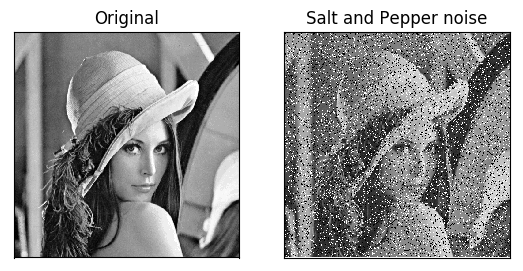

In [30]:
##### coding here......

# Step1：增加椒盐噪声
import random
def sp_noise(image,rate=0.5):
    '''
    generate salt and pepper noise
    rate:Noise ratio
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - rate
    for i in range(image.shape[0]):
        for j in range(image.shape[1]): 
            rdn = random.random()
            if rdn < rate:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

img = cv2.imread('data/lenna.bmp',flags=0)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# add salt and pepper noise
img_noise=sp_noise(img,0.09)
# img_median = cv2.medianBlur(img,5)
images=[img,img_noise]
title=['Original','Salt and Pepper noise']
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],"gray")
    plt.title(title[i])
    plt.xticks([])
    plt.yticks([])


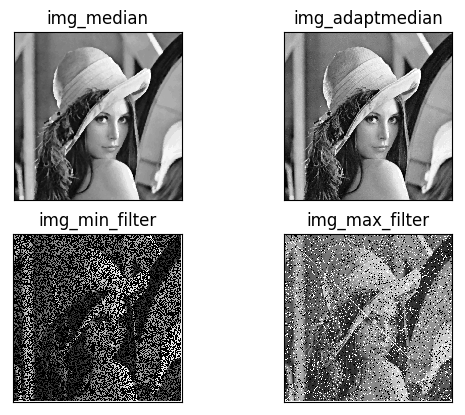

In [36]:
# # Step2：选择一个合适的滤波器


# 中值滤波器
img_median = cv2.medianBlur(img_noise,5)

# 自适应滤波器
img_adaptmedian = adaptMeadianFilter(img_noise,5,300)

# 最小滤波器
img_min_filter = min_filter(img_noise)

# 最大滤波器
img_max_filter = max_filter(img_noise)


images_show = [img_median,img_adaptmedian,img_min_filter,img_max_filter]
title_show = ['img_median','img_adaptmedian','img_min_filter','img_max_filter']

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images_show[i],"gray")
    plt.title(title_show[i])
    plt.xticks([])
    plt.yticks([])

# Estimating degenerate function（估算 退化函数）

## Atmospheric Turbulence Degeneration Model（大气湍流退变模型）
> * Hufnagel and Stanley[1964]   $H(u,v) = e^\left(-k\left(u^2+v^2\right)^5/6\right)$，k is a constant.



255 0
254 0
255 0


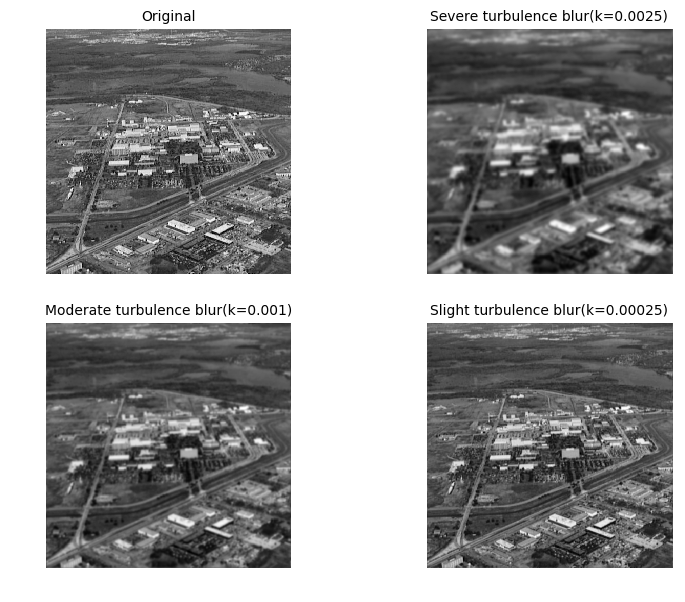

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
#  湍流模糊退化图像

#  返回湍流模糊掩膜
def turbulenceBlur(img, k=0.001):  
    M, N = img.shape[1], img.shape[0]
    # np.meshgrid生成网格点坐标矩阵
    u, v = np.meshgrid(np.arange(M), np.arange(N))
    radius = (u - M//2)**2 + (v - N//2)**2
    kernel = np.exp(-k * np.power(radius, 5/6))
    return kernel

# 根据退化模型生成退化图像
def getDegradedImg(img, Huv):  
    # 傅里叶变换, 中心化
    fft = np.fft.fft2(img.astype(np.float32))  
    fftShift = np.fft.fftshift(fft) 
    # 在频率域修改傅里叶变换
    fftShiftFilter = fftShift * Huv 
    # 进行傅里叶逆变换，逆中心化
    invShift = np.fft.ifftshift(fftShiftFilter)
    imgIfft = np.fft.ifft2(invShift) 
     # 归一化为 [0,255]
     # 在上一节中我们使用的是np.abs(imgIfft),其作用也是将结果大致转换在[0，255]这个区间
    imgDegraded = np.uint8(cv2.normalize(np.abs(imgIfft), None, 0, 255, cv2.NORM_MINMAX)) 
    return imgDegraded


# 读取原始图像
img = cv2.imread("data/aerial_view.tif", 0)  

# 生成湍流模糊图像
HTurb1 = turbulenceBlur(img, k=0.0025)
HTurb2 = turbulenceBlur(img, k=0.001)
HTurb3 = turbulenceBlur(img, k=0.00025)

imgBlur1=getDegradedImg(img,HTurb1)
imgBlur2=getDegradedImg(img,HTurb2)
imgBlur3=getDegradedImg(img,HTurb3)

print(imgBlur1.max(), imgBlur1.min())
print(imgBlur2.max(), imgBlur2.min())
print(imgBlur3.max(), imgBlur3.min())

images=[img,imgBlur1,imgBlur2,imgBlur3]
titles=['Original','Severe turbulence blur(k=0.0025)','Moderate turbulence blur(k=0.001)','Slight turbulence blur(k=0.00025)']
# [1原始，2严重退化模糊(k=0.0025)，3中度湍流模糊(k=0.001)，4轻微湍流模糊(k=0.00025)]
plt.figure(figsize=(9, 7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i],fontsize=10)
    plt.axis("off")



## Motion Blur Degradation Model（动态模糊退化模型）
> * Uniform linear motion, image $f\left(x,y\right)$ moving with a speed $ x0\left(t\right)=at/T$ , $ y0\left(t\right)=bt/T$ ,in $x$ derection and $y$ derection,the motion blur degradation model is
![](https://ai-studio-static-online.cdn.bcebos.com/b09ec19b891f42eb8aecb93ac457bd0eff91687c2dd044c887a94d9ece4ef21c)


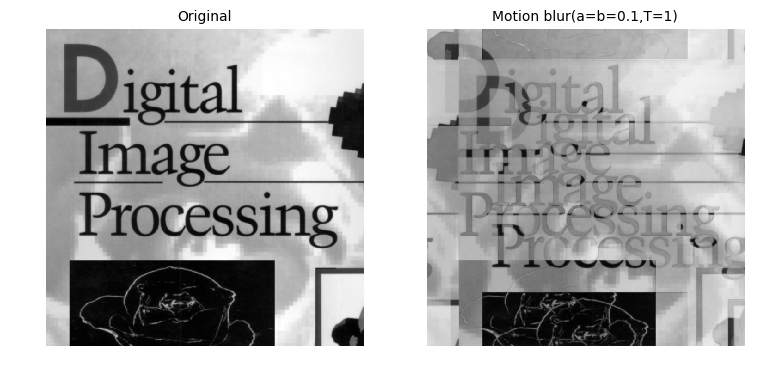

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import pi,sin

# 运动模糊退化图像 (Motion blur degradation)
def motionBlur(img, a=1, b=1, T=1):
    M, N = img.shape[1], img.shape[0]
    # np.meshgrid生成网格点坐标矩阵
    u, v = np.meshgrid(np.arange(M), np.arange(N))
    x = u*a+v*b
    kernel=T/(np.pi*x+1e-06)*np.sin(np.pi*x)*np.exp(-1j*np.pi*x)
    return kernel


# 导入图像
img = cv2.imread("data/book-cover.tif", 0)  # flags=0 读取为灰度图像
#进行运动模糊
HBlur1 = motionBlur(img, a=0.1, b=0.1, T=1)
imgBlur1=getDegradedImg(img,HBlur1)

images=[img,imgBlur1]
titles=['Original','Motion blur(a=b=0.1,T=1)']
plt.figure(figsize=(9, 7))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i],fontsize=10)
    plt.axis("off")


In [10]:
# 运动模糊退化图像 (Motion blur degradation)
# 用运动模糊核来实现
def motionBlur(img, degree=10, angle=45):
    img = np.array(img)
    # 旋转中心
    center = (degree/2, degree/2) 
    # 无损旋转,第一个参数旋转中心，第二个参数旋转角度，第三个参数：缩放比例
    M = cv2.getRotationMatrix2D(center, angle, 1)  
    # 运动模糊内核
    kernel = np.diag(np.ones(degree) / degree) 
    #仿射变换
    kernel = cv2.warpAffine(kernel, M, (degree, degree))
    # 图像卷积
    blurred = cv2.filter2D(img, -1, kernel)  
    blurredNorm = np.uint8(cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX))  # 归一化为 [0,255]
    return blurredNorm

# 运动模糊图像
img = cv2.imread("book-cover.tif", 0)

imgBlur1 = motionBlur(img, degree=30, angle=45)
imgBlur2 = motionBlur(img, degree=60, angle=45)
imgBlur3 = motionBlur(img, degree=100, angle=45)

images=[img,imgBlur1,imgBlur2,imgBlur3]
titles=['Original','degree=20','degree=60','degree=100']
plt.figure(figsize=(9,7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i],fontsize=10)
    plt.axis("off")




[ WARN:0@376.713] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('book-cover.tif'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'filter2D'
> Overload resolution failed:
>  - src data type = 17 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


# Image restoration（图像修复）
> * Restoration attempts to recover 
an image that has been degraded by using a priori knowledge of the degradation phenomenon. 
> * Thus, restoration techniques are oriented toward modeling the degradation and applying the inverse process 
in order to recover the original image> 
*恢复尝试恢复
通过使用退化现象的先验知识已经退化的图像。
*因此，恢复技术的方向是对退化进行建模并应用逆过程
为了恢复原始图像

## Unconstrained image restoration 无约束图像恢复
### Inverse filtering  反向滤波
> *
![](https://ai-studio-static-online.cdn.bcebos.com/019bb4dfa45549f683a9ebf9950a26250128269221eb4ea6806809971edac45a)




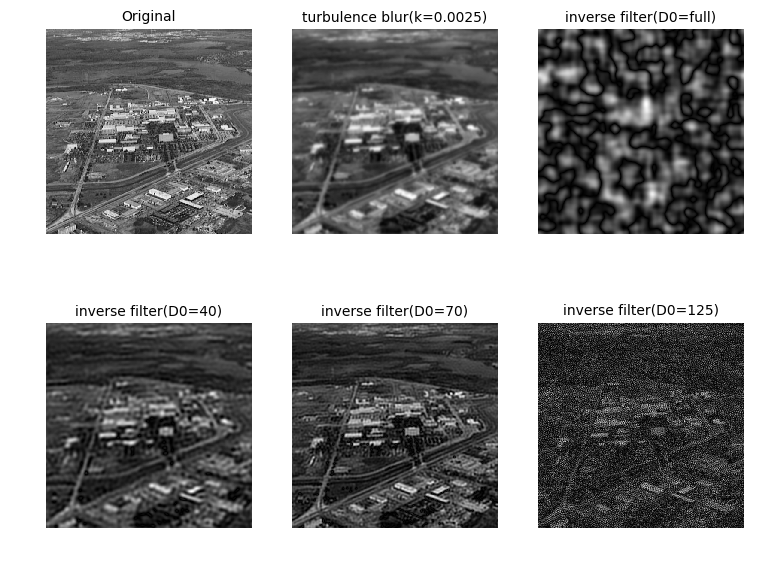

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 理想低通滤波器,返回掩膜
def BLPFilter(img, radius=10):  
    M, N = img.shape[1], img.shape[0]
    u, v = np.meshgrid(np.arange(M), np.arange(N))
    D = np.sqrt((u - M//2)**2 + (v - N//2)**2)
    kernel = np.zeros(img.shape[:2], np.float32)
    kernel[D <= radius] = 1
    return kernel

#逆滤波复原，返回经处理后的图像
def inverseFilter(img, Huv, D0):  
    # 傅里叶变换, 中心化
    fft = np.fft.fft2(img.astype(np.float32)) 
    fftShift = np.fft.fftshift(fft) 
    # 在频率域修改傅里叶变换
    lpFilter = BLPFilter(img,radius=D0)
    fftShiftFilter = fftShift / Huv * lpFilter 

    # 进行傅里叶逆变换，逆中心化
    invShift = np.fft.ifftshift(fftShiftFilter) 
    imgIfft = np.fft.ifft2(invShift)  
    imgRebuild = np.uint8(cv2.normalize(np.abs(imgIfft), None, 0, 255, cv2.NORM_MINMAX)) 
    return imgRebuild


# 读取原始图像
img = cv2.imread("data/aerial_view.tif", 0)  # flags=0 读取为灰度图像

# 生成湍流模糊图像
HTurb = turbulenceBlur(img, k=0.0025)
imgBlur = getDegradedImg(img, HTurb)

#逆滤波
imgRebuild = inverseFilter(imgBlur, HTurb,  D0=480)
imgRebuild1 = inverseFilter(imgBlur, HTurb, D0=40)  
imgRebuild2 = inverseFilter(imgBlur, HTurb, D0=70)
imgRebuild3 = inverseFilter(imgBlur, HTurb, D0=125)

#display
images=[img,imgBlur,imgRebuild,imgRebuild1,imgRebuild2,imgRebuild3]
titles=['Original','turbulence blur(k=0.0025)','inverse filter(D0=full)','inverse filter(D0=40)','inverse filter(D0=70)','inverse filter(D0=125)']
plt.figure(figsize=(9, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i],fontsize=10)
    plt.axis("off")


## exercise2
> * With the increase of the filter radius, the image is getting clearer, while further increasing the radius will only make the image worse and worse
> * give your explanation


** your explanation here...... ** 







## Constrained image restoration(受限图像恢复)
### Wiener filtering（维纳滤波）
> * Wiener [1942] 
> * ![](https://ai-studio-static-online.cdn.bcebos.com/c089622a505e45638ff1eb07b0183235db15aec9ba6a45fbb25dbf37faf82c83)
> * ![](https://ai-studio-static-online.cdn.bcebos.com/95912c01bd6447b6ac45880a3f0c998d1d7d7db357c54de5b4d39f4fdfaafc52)



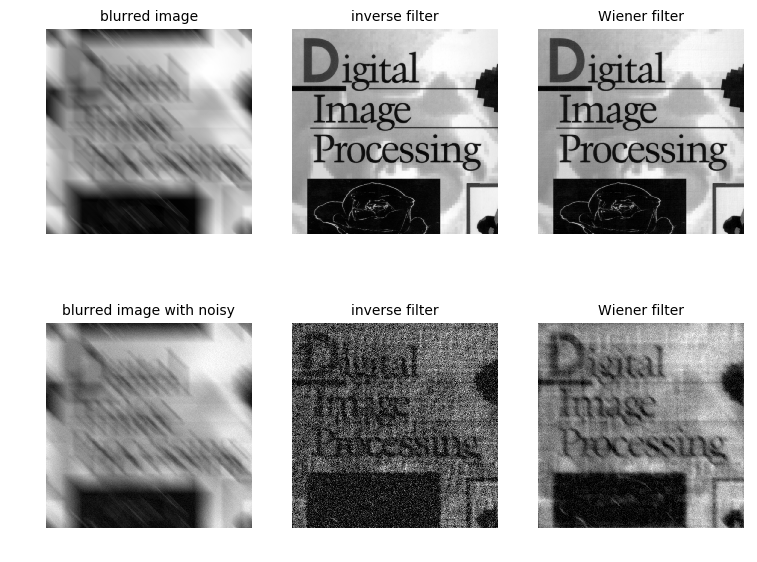

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#  退化图像的维纳滤波 (Wiener filter)
def getMotionDsf(img, angle, dist):
    xCenter = img.shape[0]// 2
    yCenter = img.shape[1]// 2
    sinVal = np.sin(angle * np.pi / 180)
    cosVal = np.cos(angle * np.pi / 180)
     # 点扩散函数
    PSF = np.zeros(img.shape[:2]) 
    # 将对应角度上motion_dis个点置成1
    for i in range(dist):  
        xOffset = round(sinVal * i)
        yOffset = round(cosVal * i)
        PSF[int(xCenter - xOffset), int(yCenter + yOffset)] = 1
        # 归一化
    return PSF / PSF.sum()

# 对图片进行运动模糊,返回经运动模糊的图片
def makeBlurred(img, PSF, eps):
    # 进行二维数组的傅里叶变换 
    fftImg = np.fft.fft2(img)  
    fftPSF = np.fft.fft2(PSF) + eps
    fftBlur = np.fft.ifft2(fftImg * fftPSF)
    fftBlur = np.abs(np.fft.fftshift(fftBlur))
    return fftBlur

 # 逆滤波,返回处理后的图像
def inverseFilter(img, PSF, eps): 
    fftImg = np.fft.fft2(img)
    # 噪声功率，这是已知的，考虑epsilon
    fftPSF = np.fft.fft2(PSF) + eps  
    #傅里叶反变换
    imgInvFilter = np.fft.ifft2(fftImg / fftPSF) 
    imgInvFilter = np.abs(np.fft.fftshift(imgInvFilter))
    return imgInvFilter

# 维纳滤波，K=0.01
def wienerFilter(img, PSF, eps, K=0.01):  
    fftImg = np.fft.fft2(img)
    fftPSF = np.fft.fft2(PSF) + eps
    # np.conj返回共轭
    fftWiener = np.conj(fftPSF) / (np.abs(fftPSF)**2 + K)
    imgWienerFilter = np.fft.ifft2(fftImg * fftWiener)
    imgWienerFilter = np.abs(np.fft.fftshift(imgWienerFilter))
    return imgWienerFilter


# 读取原始图像
img = cv2.imread("data/book-cover.tif", 0)  

# 不含噪声的运动模糊
PSF = getMotionDsf(img, -45, 100)
imgBlurred = makeBlurred(img, PSF, 1e-6)
imgInvFilter = inverseFilter(imgBlurred, PSF, 1e-6)
imgWienerFilter = wienerFilter(imgBlurred, PSF, 1e-6 ,K=0.000001) 

# 带有噪声的运动模糊
# 噪声方差
scale = 0.05 
# 添加高斯噪声
noisy = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale, size=imgBlurred.shape) 
# 带有噪声的运动模糊
imgBlurNoisy = imgBlurred + noisy
# 对添加噪声的模糊图像进行逆滤波
imgNoisyInv = inverseFilter(imgBlurNoisy, PSF, scale)  
# 对添加噪声的模糊图像进行维纳滤波
imgNoisyWiener = wienerFilter(imgBlurNoisy, PSF, scale,K=0.01)

#display
images=[imgBlurred,imgInvFilter,imgWienerFilter,imgBlurNoisy,imgNoisyInv,imgNoisyWiener]
titles=['blurred image','inverse filter','Wiener filter','blurred image with noisy','inverse filter','Wiener filter']
# [“模糊图像”，“逆滤波器”，“维纳滤波器”，“带噪声的模糊图像”，“逆滤波器”，“维纳滤波器”]
plt.figure(figsize=(9, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i],fontsize=10)
    plt.axis("off")



> * For motion blurred images without noise, under the prior knowledge of the motion blur degradation model and parameters, the inverse filter can be used to restore the degraded images, and its performance is better than that of Wiener filter. However, considering that the actual degraded image often contains a certain level of additive noise, even if the degradation model is known, the noise after inverse filtering almost covers the result image, while the result of Wiener filtering is better.
对于无噪声的运动模糊图像，在对运动模糊退化模型和参数的先验知识下，可以使用逆滤波器对退化图像进行恢复，其性能优于维纳滤波器。但是，考虑到实际退化图像往往含有一定程度的加性噪声，即使退化模型已知，反滤波后的噪声几乎覆盖了结果图像，而维纳滤波的结果更好。

### Constrained least squares filtering(约束最小二乘滤波)
> * ![](https://ai-studio-static-online.cdn.bcebos.com/5dab08e65c564ca99671e5752043b6857160c3967a044ffb82781926579f7b90)
> * $ \gamma $ is a parameter, $P(U,V)$ is $p(x,y)$ fourier transform
![](https://ai-studio-static-online.cdn.bcebos.com/1fc8232665b34c00ab5b64ba190df499f1115298f8584b15863e8adacde29bf7)
> * $P ( u , v ) $ and $H ( u , v ) $ are the same size.

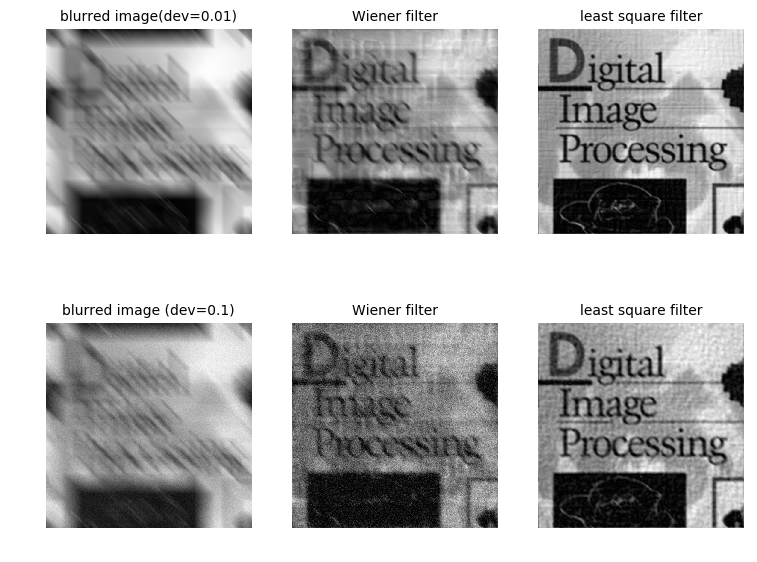

In [16]:
#返回P(u,v)
def getPuv(img):
    h, w = img.shape[:2]
    hPad, wPad = h - 3, w - 3
    pxy = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    pxyPad = np.pad(pxy, ((hPad//2, hPad - hPad//2), (wPad//2, wPad - wPad//2)), mode='constant')
    fftPuv = np.fft.fft2(pxyPad)
    return fftPuv

# 约束最小二乘方滤波
def leastSquareFilter(img, PSF, eps, gamma=0.01):  
    fftImg = np.fft.fft2(img)
    fftPSF = np.fft.fft2(PSF)
    conj = fftPSF.conj()
    fftPuv = getPuv(img)

    Huv = conj / (np.abs(fftPSF)**2 + gamma * (np.abs(fftPuv)**2))
    ifftImg = np.fft.ifft2(fftImg * Huv)
    ifftShift = np.abs(np.fft.fftshift(ifftImg))
    imgLSFilter = np.uint8(cv2.normalize(np.abs(ifftShift), None, 0, 255, cv2.NORM_MINMAX))  # 归一化为 [0,255]
    return imgLSFilter

# # 读取原始图像
img = cv2.imread("data/book-cover.tif", 0)

# 带有噪声的运动模糊
PSF = getMotionDsf(img, -45, 100)  
imgBlurred = makeBlurred(img, PSF, 1e-6) 

# 噪声方差
scale1 = 0.01  
# 添加高斯噪声
noisy1 = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale1, size=imgBlurred.shape)  
# 带有噪声的运动模糊
imgBlurNoisy1 = imgBlurred + noisy1  
# 对含有噪声的模糊图像进行维纳滤波
imgWienerFilter1 = wienerFilter(imgBlurNoisy1, PSF, scale, K=0.01)  
# 约束最小平方滤波
imgLSFilter1 = leastSquareFilter(imgBlurNoisy1, PSF, scale, gamma=0.01)  

# 噪声方差
scale2 = 0.1
# 添加高斯噪声
noisy2 = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale2, size=imgBlurred.shape)  
 # 带有噪声的运动模糊
imgBlurNoisy2 = imgBlurred + noisy2 
# 维纳滤波
imgWienerFilter2 = wienerFilter(imgBlurNoisy2, PSF, scale, K=0.01) 
# 约束最小平方滤波
imgLSFilter2 = leastSquareFilter(imgBlurNoisy2, PSF, scale, gamma=0.1)  

#display
images=[imgBlurNoisy1,imgWienerFilter1,imgLSFilter1,imgBlurNoisy2,imgWienerFilter2,imgLSFilter2]
titles=['blurred image(dev=0.01)','Wiener filter','least square filter','blurred image (dev=0.1)','Wiener filter','least square filter']
# “模糊图像(dev=0.01)”，“维纳滤波器”，“最小二乘滤波器”，“模糊图像(dev=0.1)”，“维纳滤波器”，“最小二乘滤波器”
plt.figure(figsize=(9, 7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],"gray")
    plt.title(titles[i],fontsize=10)
    plt.axis("off")
